In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pyscipopt import Model, SCIP_STATUS

In [2]:
# RD 天數
max_rd = 18

In [3]:
'''需求模型'''
class demandmodel:
    def __init__(self):
        self.seat_set = ['Y', 'M', 'K']
        self.seat_price = {'Y': 800, 'M': 500, 'K': 450}  
        self.total_booking = 105
        self.market_share = 0.25
        self.gamma = 0.08426
        self.alpha = 0.001251
        self.beta = {'DFARE':-0.006, 'LOT3':-0.944}
        self.a = {'Y':{'DFARE':800, 'LOT3':1},
                  'M':{'DFARE':500, 'LOT3':1},
                  'K':{'DFARE':450, 'LOT3':1},
                 }
        self.fare_diff_avg = sum(self.seat_price.values()) / len(self.seat_price)

        for seat_type in self.a:
            self.a[seat_type]['DFARE'] = round(self.a[seat_type]['DFARE'] - self.fare_diff_avg, 2)

    def dm(self):
        dm = self.total_booking/self.market_share
        return dm

    def booking_curve(self, RD2, RD1):
        booking_curve = math.exp(-self.gamma*RD2)-math.exp(-self.gamma*RD1)
        return booking_curve

    def find_pj1(self, seat):
        smaller_keys = [key for key in self.seat_price.keys() if key < seat]
        if smaller_keys:
            max_smaller_key = max(smaller_keys)
            pj1 = self.seat_price[max_smaller_key]
        else:
            pj1 = min(self.seat_price.values())
        return pj1

    def mnl(self):
        choose_prob = {}
        value_dict = {}
        for seat in self.seat_set:
            result = {key: self.beta[key] * value for key, value in self.a[seat].items()}
            total = sum(result.values())
            value = math.exp(total)
            value_dict[seat] = value
        for seat in value_dict:
            exp_value = math.exp(value_dict[seat])
            choose_prob[seat] = exp_value / sum(math.exp(value) for value in value_dict.values())
        print("mnl: ", choose_prob)
        return choose_prob

    def customer_choice(self, seat_type):
        total_sum = 0
        choose_prob = self.mnl()
        min_key = min(self.seat_price, key=self.seat_price.get)
        p0 = self.seat_price[min_key]
        for seat in self.seat_set:
            # pj = self.seat_price[seat]
            # pj1 = self.find_pj1(seat)
            pj = self.seat_price['Y'] # 暫時寫這樣
            pj1 = self.seat_price['M'] # 暫時寫這樣
            print('p0: ',p0 , 'p1: ', pj, 'pj1: ', pj1)
            sum_of_set = (math.exp(-self.alpha*(pj-p0))-math.exp(-self.alpha*(pj1-p0))) * choose_prob[seat_type] 
            print('sum of set: ', sum_of_set)
            total_sum += sum_of_set
        return total_sum

    def formulation(self, RD2, RD1):
        dm = self.dm()
        print('dm',dm)
        booking_curve = self.booking_curve(RD2, RD1)
        print('booking curve: ',booking_curve)
        BR_dict = {}
        
        for seat in self.seat_set:
            print("calculate", seat, " ing...")
            customer_choice = self.customer_choice(seat)
            print('customer choice', customer_choice)
            BR = dm * booking_curve * customer_choice
            BR_dict[seat] = BR
            print(' seat: ', seat, ' predicted demand model from ', RD2,' to ', RD1, 'is', BR)
        return BR_dict

In [4]:
model = demandmodel()

# 存儲資訊的字典們
every_rd = {seat: [] for seat in model.seat_set}  
cumulative_demand = {seat: [] for seat in model.seat_set}  
total_demand = {seat: 0 for seat in model.seat_set}  
cumulative_total_demand_per_rd = []  # 存儲每個RD的累積總需求

# 計算所有RD需求
cumulative_total_demand = 0  # 初始累積總需求
for i in range(2, max_rd+1):
    print('i: ', i)
    BR_results = model.formulation(i, i-1)  
    total_demand_rd = sum(BR_results.values())  # 計算每個時間段的總需求
    cumulative_total_demand += total_demand_rd  # 更新累積總需求
    cumulative_total_demand_per_rd.append(cumulative_total_demand)  # 將累積總需求添加到列表中
    for seat, demand in BR_results.items():  
        every_rd[seat].append(demand) 
        total_demand[seat] += demand  
        cumulative_demand[seat].append(total_demand[seat])  

print('Total demand for each seat: ', total_demand)
print('Total demand: ', sum(total_demand.values()))

i:  2
dm 420.0
booking curve:  -0.07427787007997011
calculate Y  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
p0:  450 p1:  800 pj1:  500
sum of set:  -0.06065568770983491
customer choice -0.18196706312950472
 seat:  Y  predicted demand model from  2  to  1 is 5.67677286706617
calculate M  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
p0:  450 p1:  800 pj1:  500
sum of set:  -0.10361007784769294
customer choice -0.3108302335430788
 seat:  M  predicted demand model from  2  to  1 is 9.696879235696622
calculate K  ing...
mnl:  {'Y': 0.20635151589435508, 'M': 0.35248296463279466, 'K': 0.4411655194728502}
p0:  450 p1:  800 pj1:  500
sum of set:  -0.12967773

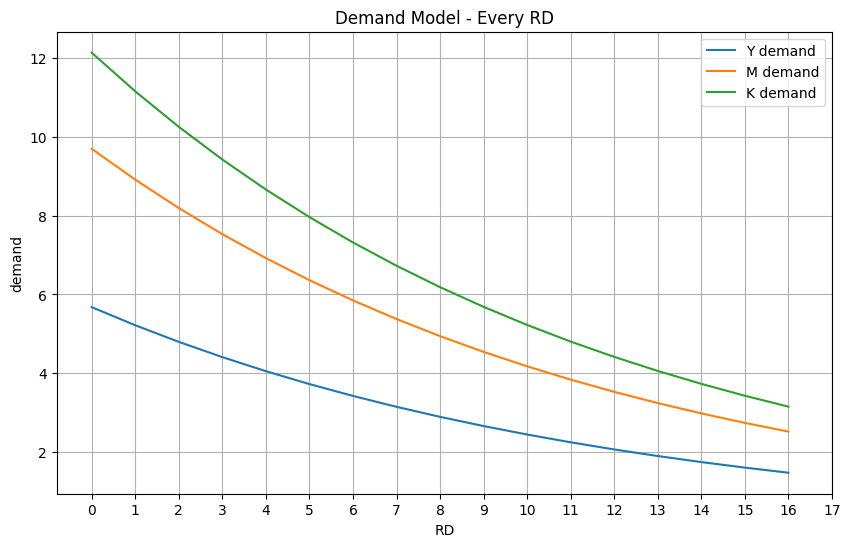

In [5]:
# 繪製每個RD的需求
plt.figure(figsize=(10, 6))
for seat, demands in every_rd.items():
    plt.plot(range(len(demands)), demands, label=f'{seat} demand')

plt.xlabel('RD')
plt.ylabel('demand')
plt.title('Demand Model - Every RD')
plt.legend()
plt.xticks(range(0, max_rd, int(max_rd/10)))
plt.grid(True)
plt.show()

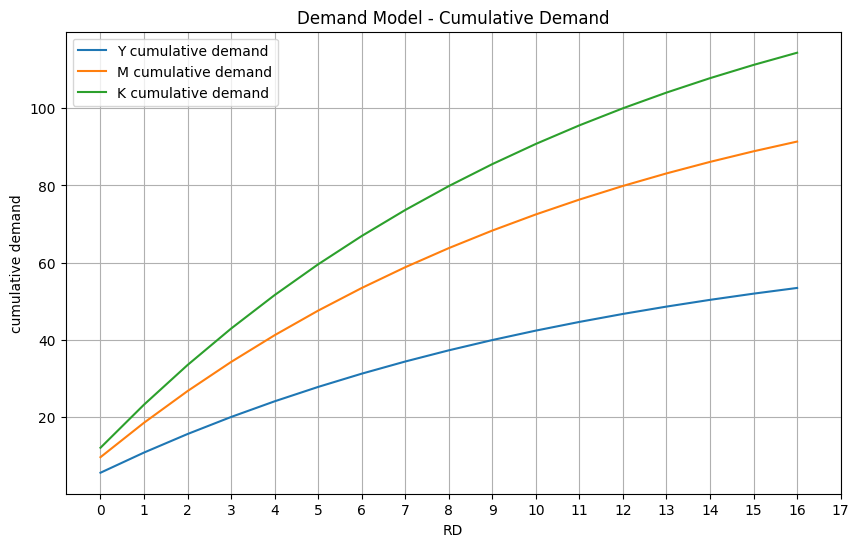

In [6]:
# 繪製累積需求
plt.figure(figsize=(10, 6))
for seat, demands in cumulative_demand.items():
    plt.plot(range(len(demands)), demands, label=f'{seat} cumulative demand')

plt.xlabel('RD')
plt.ylabel('cumulative demand')
plt.title('Demand Model - Cumulative Demand')
plt.legend()
plt.xticks(range(0, max_rd, int(max_rd/10)))
plt.grid(True)
plt.show()

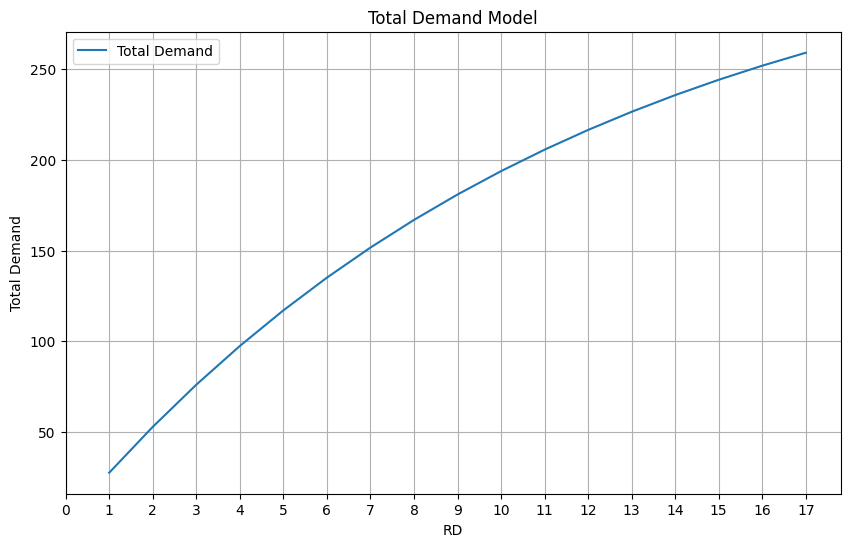

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_rd), cumulative_total_demand_per_rd, label='Total Demand')
plt.xlabel('RD')
plt.ylabel('Total Demand')
plt.title('Total Demand Model')
plt.legend()
plt.xticks(range(0, max_rd, int(max_rd/10)))
plt.grid(True)
plt.show()

In [8]:
# period 參數
min_time = 1
max_time = max_rd * 15

In [9]:
def solve_NHPP(min_time, max_time, y2, y5, y8, total_demand):

    # 創建 SCIP 模型
    model = Model("NHPP")

    # 三角形 1
    x1 = model.addVar(vtype="I", name="x1")
    x2 = model.addVar(vtype="I", name="x2")
    x3 = model.addVar(vtype="I", name="x3")
    
    # 三角形 2
    x4 = model.addVar(vtype="I", name="x4")
    x5 = model.addVar(vtype="I", name="x5")
    x6 = model.addVar(vtype="I", name="x6")
    
    # 三角形 3
    x7 = model.addVar(vtype="I", name="x7")
    x8 = model.addVar(vtype="I", name="x8")
    x9 = model.addVar(vtype="I", name="x9")

    # 限制式
    model.addCons((x3-x1)*y2/2 >= 5)
    model.addCons((x6-x4)*y5/2 >= 5)
    model.addCons((x9-x7)*y8/2 >= 5)
    
    # 添加所有變數大於等於 0 的限制
    model.addCons(x1 >= min_time)
    model.addCons(x2 >= min_time + int(max_time/10))
    model.addCons(x3 >= max_time)
    model.addCons(x4 >= min_time)
    model.addCons(x5 >= min_time + int(max_time/10))
    model.addCons(x6 >= min_time)
    model.addCons(x7 >= min_time + 40)
    model.addCons(x8 >= max_time - 50)
    model.addCons(x9 >= min_time)
    
    # 上限
    model.addCons(x1 <= min_time)
    model.addCons(x2 <= max_time)
    model.addCons(x3 <= max_time)
    model.addCons(x4 <= min_time)
    model.addCons(x5 <= max_time)
    model.addCons(x6 <= max_time - 90)
    model.addCons(x7 <= min_time + 60)
    model.addCons(x8 <= max_time - 30)
    model.addCons(x9 <= max_time)
    
    
    # 限制 x1、x2、x3 的順序
    model.addCons(x1 <= x2)
    model.addCons(x2 <= x3)
    
    # 限制 x4、x5、x6 的順序
    model.addCons(x4 <= x5)
    model.addCons(x5 <= x6)
    
    # 限制 x7、x8、x9 的順序
    model.addCons(x7 <= x8)
    model.addCons(x8 <= x9 - 10)

    # 限制 x7、x8、x9 的順序
    model.addCons(x2 <= x8 - 80)
    model.addCons(x5 <= x2 - 50)

    model.addCons((x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2 <= total_demand)
    model.addCons(0 <= (x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2)

    # 最小化面積與總需求差距
    obj = total_demand - ((x3-x1)*y2/2 + (x6-x4)*y5/2 + (x9-x7)*y8/2)
    model.setObjective(obj, "minimize")

    # 求解
    model.optimize()
    obj_set = model.getBestSol()
    print("obj set：", obj_set)
    obj_value = model.getObjVal()
    print("obj： ", obj_value)
    
    # 解
    x1_val = model.getVal(x1)
    x2_val = model.getVal(x2)
    x3_val = model.getVal(x3)
    x4_val = model.getVal(x4)
    x5_val = model.getVal(x5)
    x6_val = model.getVal(x6)
    x7_val = model.getVal(x7)
    x8_val = model.getVal(x8)
    x9_val = model.getVal(x9)

    return x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val

    
# 測試函式
total_demand_sim = int(sum(total_demand.values()))
print(total_demand_sim)
max_Y = 0.3
max_M = 0.85
max_K = 0.85
result = solve_NHPP(min_time, max_time, max_Y, max_M, max_K, total_demand_sim)
if result:
    x1_val, x2_val, x3_val, x4_val, x5_val, x6_val, x7_val, x8_val, x9_val = result
    print("x1:", x1_val)
    print("x2:", x2_val)
    print("x3:", x3_val)
    print("x4:", x4_val)
    print("x5:", x5_val)
    print("x6:", x6_val)
    print("x7:", x7_val)
    print("x8:", x8_val)
    print("x9:", x9_val)

259
obj set： {'x1': 1.0, 'x2': 140.0, 'x3': 270.0, 'x4': 1.0, 'x5': 28.0, 'x6': 180.0, 'x7': 41.0, 'x8': 220.0, 'x9': 270.0}
obj：  45.25
x1: 1.0
x2: 140.0
x3: 270.0
x4: 1.0
x5: 28.0
x6: 180.0
x7: 41.0
x8: 220.0
x9: 270.0


In [10]:
'''繪製 NHHP 三角形'''
def NHHP_triangle(min_val, max_val, left, middle, right, color='b', name=''):
    
    # 檢查中間端點的y值是否在 0 到 1 之間
    if not (0 <= middle[1] <= 1):
        print("錯誤：中間端點的y值必須在0到1之間")
        return
    
    # 計算三角形的頂點
    x1, _ = left
    x2, y2 = middle
    x3, _ = right
    
    # 計算三角形上的 y 值
    y1 = 0.0
    y3 = 0.0
    
    # 為了繪製三角形，創建 x 和 y 的坐標陣列
    x = [x1, x2, x3, x1] # 左、中、右端點構成三角形的四個點（第四個點是第一個點，閉合三角形）
    y = [y1, y2, y3, y1]
    
    # 繪製三角形
    plt.plot(x, y, color + '-', label=name)

In [11]:
# 三角形 1 的端點
left_point_y = (x1_val, 0)  # 左端點
middle_point_y = (x2_val, max_Y)  # 中間端點
right_point_y = (x3_val, 0)  # 右端點

# 三角形 2 的端點
left_point_m = (x4_val, 0)  # 左端點
middle_point_m = (x5_val, max_M)  # 中間端點
right_point_m = (x6_val, 0)  # 右端點

# 三角形 3 的端點
left_point_k = (x7_val, 0)  # 左端點
middle_point_k = (x8_val, max_K)  # 中間端點
right_point_k = (x9_val, 0)  # 右端點

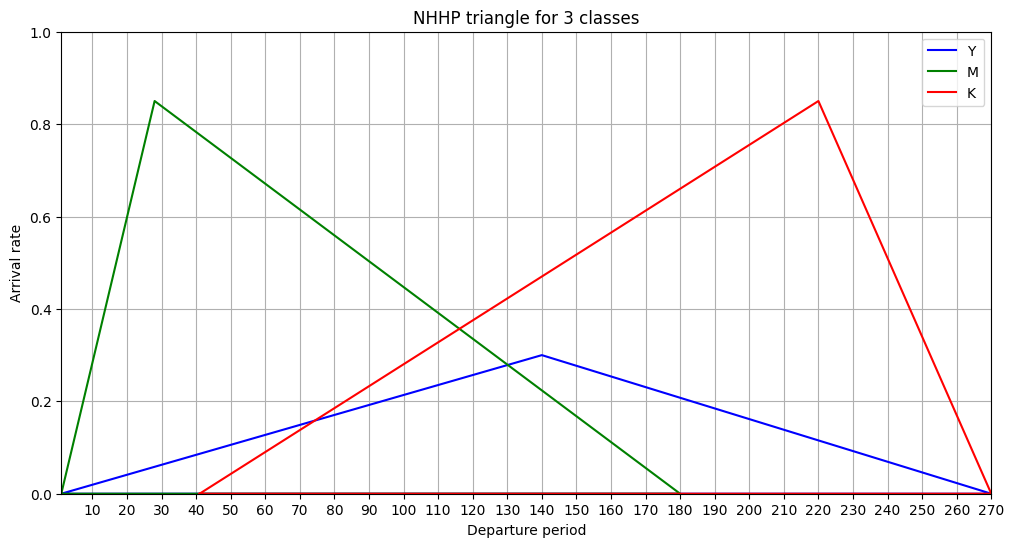

In [12]:
# 繪製三角形並為其命名
NHHP_triangle(min_time, max_time, left_point_y, middle_point_y, right_point_y, color='b', name='Y')
NHHP_triangle(min_time, max_time, left_point_m, middle_point_m, right_point_m, color='g', name='M')
NHHP_triangle(min_time, max_time, left_point_k, middle_point_k, right_point_k, color='r', name='K')

# 設置圖形的標題和坐標軸標籤
plt.title('NHHP triangle for 3 classes')
plt.xlabel('Departure period')
plt.ylabel('Arrival rate')

# 設置 x 軸刻度以 10 為單位顯示到最後
plt.xticks(range(min_time-1, max_time+1, 10))

# 設置 x 和 y 軸範圍
plt.xlim(min_time, max_time)
plt.ylim(0, 1)

# 設置圖的寬度
plt.gcf().set_size_inches(12, 6)

# 顯示圖例
plt.legend()

# 顯示圖形
plt.grid(True)
plt.show()

In [13]:
'''使用線性差值法計算數值'''
def interpolate(x, x1, y1, x2, y2):
    return round(y1 + (x - x1) * (y2 - y1) / (x2 - x1), 3)

In [14]:
'''將三角形轉換成 NHHP'''
def NHHP(min_val, max_val, left, middle, right, color='b'):
    
    # 檢查中間端點的 y 值是否在 0 到 1 之間
    if not (0 <= middle[1] <= 1):
        print("錯誤：中間端點的 y 值必須在0到1之間")
        return
    
    # 設定端點
    x1, y1 = left
    x2, y2 = middle
    x3, y3 = right
    
    # 儲存 x 對應到中間點直線的 y 值列表
    interpolated_y_values = []
    
    # 對每個 x 值進行線性插值計算
    for x in range(min_val, max_val + 1):
        
        # 如果 x 在左端點和中間點之間
        if x1 <= x <= x2:
            interpolated_y = interpolate(x, x1, y1, x2, y2)
            interpolated_y_values.append(interpolated_y)
        
        # 如果 x 在中間點和右端點之間
        elif x2 <= x <= x3:
            interpolated_y = interpolate(x, x2, y2, x3, y3)
            interpolated_y_values.append(interpolated_y)
        
        # 如果 x 超出右端點範圍，將 y 值設置為 0
        elif x > x3:
            # print(x)
            interpolated_y_values.append(0.0)
        
        # 如果 x 超出範圍，y 設 0
        else:
            interpolated_y_values.append(0.0)
    
    # 返回 x 對應到中間點直線的 y 值列表
    return interpolated_y_values

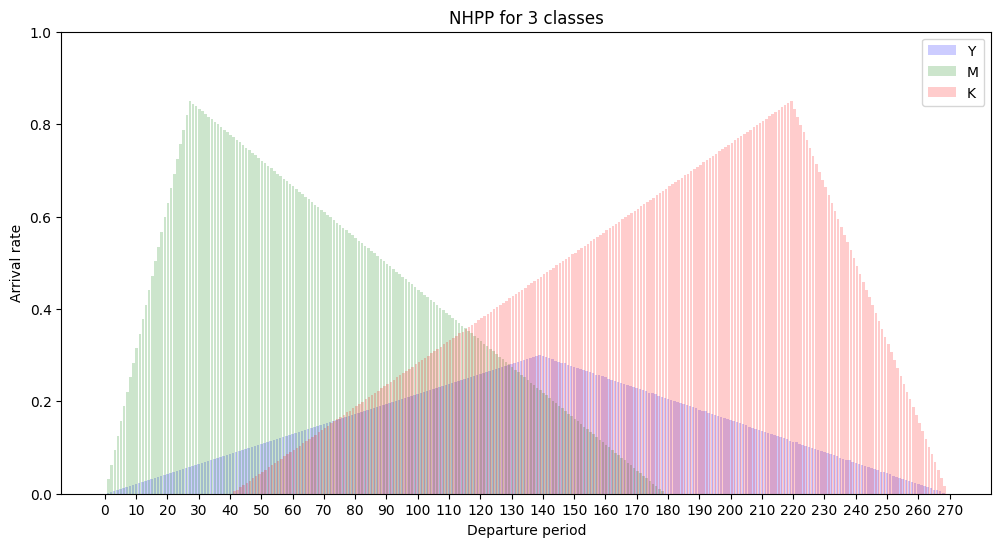

In [15]:
# 儲存每個三角形的 x 值列表和名稱的字典
triangle_data = {
    'Y': (left_point_y, middle_point_y, right_point_y),
    'M': (left_point_m, middle_point_m, right_point_m),
    'K': (left_point_k, middle_point_k, right_point_k)
}

# 儲存每個三角形的 x 值列表和名稱的字典
triangle_y_values = []

# 調用函數繪製三角形並儲存 x 值列表
for name, points in triangle_data.items():
    left, middle, right = points
    y_values = NHHP(min_time, max_time, left, middle, right)
    triangle_y_values.append((y_values, name))

# 取得每個三角形的 x 值範圍
x_values = range(min_time-1, max_time)

# 創建圖形和子圖
plt.figure(figsize=(10, 5))
plt.title('NHPP for 3 classes')
plt.xlabel('Departure period')
plt.ylabel('Arrival rate')

# 遍歷三個三角形的 Y 值列表並繪製長條圖
for i, (y_values, name) in enumerate(triangle_y_values):
    # 調整 x 軸值，讓每個三角形的長條圖不會重疊在一起
    x_offset = i * 0.2  # 調整此值以設定長條圖的間距
    colors = ['b', 'g', 'r'] # 指定顏色
    plt.bar([x + x_offset for x in x_values], y_values, alpha=0.2, label=name, color=colors[i])

# 顯示圖例
plt.legend()

# 設置圖的寬度
plt.gcf().set_size_inches(12, 6)

# 設置 x 軸刻度以 10 為單位顯示到最後
plt.xticks(range(min_time-1, max_time+1, 10))

# 設置 y 軸範圍，將高度固定為1
plt.ylim(0, 1)

# 顯示圖形
plt.show()

In [16]:
'''檢查 NHHP 是否符合要求，同時計算到達率'''
def check_NHHP(triangle_y_values):
    
    # 獲取每個三角形的 Y 值列表的長度
    y_length = len(triangle_y_values[0][0])

    # 初始化標誌變數，用於標記是否有任何索引位置的加總值大於1
    has_greater_than_1 = False
    
    # 儲存每個索引位置的加總值
    arrival_rates = []
    non_arrival_rates = []

    # 遍歷每個索引位置
    for i in range(y_length):

        total = 0 # 初始化每個三角形的加總值
        print('Departure day:', i + 1)
        
        # 遍歷每個三角形的 Y 值列表
        for y_values, name in triangle_y_values:
            
            # 獲取當前索引位置的值並加總
            value = y_values[i]
            total += value
            
            # 印出 Y[i]、M[i]、K[i] 以及加總值
            print(f'{name}[{i}] = {value}')

        # 儲存每個索引位置的加總值
        total = round(total, 3)
        arrival_rates.append(total)
        
        # 如果加總值大於1，印出相應的資訊並設置標誌變數
        if total > 1:
            print(f'在索引 {i} 位置的加總值為 {total} 大於 1')
            has_greater_than_1 = True
        
        # 印出三個列表在當前索引位置的加總值
        print(f'Total = {total}')
    
    # 如果沒有任何索引位置的加總值大於1，回傳True；否則，回傳False
    return not has_greater_than_1, arrival_rates

In [17]:
# 執行
result, arrival_rates = check_NHHP(triangle_y_values)
print('\nNHHP acceptable\n' if result else '\nNHHP not acceptable\n')
# print('Arrival rates:', arrival_rates)

Departure day: 1
Y[0] = 0.0
M[0] = 0.0
K[0] = 0.0
Total = 0.0
Departure day: 2
Y[1] = 0.002
M[1] = 0.031
K[1] = 0.0
Total = 0.033
Departure day: 3
Y[2] = 0.004
M[2] = 0.063
K[2] = 0.0
Total = 0.067
Departure day: 4
Y[3] = 0.006
M[3] = 0.094
K[3] = 0.0
Total = 0.1
Departure day: 5
Y[4] = 0.009
M[4] = 0.126
K[4] = 0.0
Total = 0.135
Departure day: 6
Y[5] = 0.011
M[5] = 0.157
K[5] = 0.0
Total = 0.168
Departure day: 7
Y[6] = 0.013
M[6] = 0.189
K[6] = 0.0
Total = 0.202
Departure day: 8
Y[7] = 0.015
M[7] = 0.22
K[7] = 0.0
Total = 0.235
Departure day: 9
Y[8] = 0.017
M[8] = 0.252
K[8] = 0.0
Total = 0.269
Departure day: 10
Y[9] = 0.019
M[9] = 0.283
K[9] = 0.0
Total = 0.302
Departure day: 11
Y[10] = 0.022
M[10] = 0.315
K[10] = 0.0
Total = 0.337
Departure day: 12
Y[11] = 0.024
M[11] = 0.346
K[11] = 0.0
Total = 0.37
Departure day: 13
Y[12] = 0.026
M[12] = 0.378
K[12] = 0.0
Total = 0.404
Departure day: 14
Y[13] = 0.028
M[13] = 0.409
K[13] = 0.0
Total = 0.437
Departure day: 15
Y[14] = 0.03
M[14] = 0.

In [18]:
# 定義參數
seat_type = ['Y', 'M', 'K', 'YM', 'YK', 'MK', 'YMK'] # 座位種類
seats = 80 # 座位數
time_space = max_time # 時間長度

In [19]:
# 座位選擇機率矩陣
PS = {
    'f': {'PY(S)': 0.0, 'PM(S)': 0.0, 'PK(S)': 0.0, 'P0(S)': 1.0, 'Q(S)': 0.0, 'R(S)': 0.0},
    'Y': {'PY(S)': 0.3, 'PM(S)': 0.0, 'PK(S)': 0.0, 'P0(S)': 0.7, 'Q(S)': 0.3, 'R(S)': 240.0},
    'M': {'PY(S)': 0.0, 'PM(S)': 0.6, 'PK(S)': 0.0, 'P0(S)': 0.4, 'Q(S)': 0.6, 'R(S)': 300.0},
    'K': {'PY(S)': 0.0, 'PM(S)': 0.0, 'PK(S)': 0.5, 'P0(S)': 0.5, 'Q(S)': 0.5, 'R(S)': 225.0},
    'YM': {'PY(S)': 0.1, 'PM(S)': 0.6, 'PK(S)': 0.0, 'P0(S)': 0.3, 'Q(S)': 0.7, 'R(S)': 380.0},
    'YK': {'PY(S)': 0.3, 'PM(S)': 0.0, 'PK(S)': 0.5, 'P0(S)': 0.2, 'Q(S)': 0.8, 'R(S)': 465.0},
    'MK': {'PY(S)': 0.0, 'PM(S)': 0.4, 'PK(S)': 0.5, 'P0(S)': 0.1, 'Q(S)': 0.9, 'R(S)': 425.0},
    'YMK': {'PY(S)': 0.1, 'PM(S)': 0.4, 'PK(S)': 0.5, 'P0(S)': 0.0, 'Q(S)': 1.0, 'R(S)': 505.0}
}

In [20]:
# 各個組合座位的 p_j 值
p_j = {
    'f': {'f': 0.0, 'Y': 0.0, 'M': 0.0, 'K': 0.0},
    'Y': {'f': 0.0, 'Y': 800, 'M': 0.0, 'K': 0.0},
    'M': {'f': 0.0, 'Y': 0.0, 'M': 500, 'K': 0.0},
    'K': {'f': 0.0, 'Y': 0.0, 'M': 0.0, 'K': 450},
    'YM': {'f': 0.0, 'Y': 800, 'M': 500, 'K': 0.0},
    'YK': {'f': 0.0, 'Y': 800, 'M': 0.0, 'K': 450},
    'MK': {'f': 0.0, 'Y': 0.0, 'M': 500, 'K': 450},
    'YMK': {'f': 0.0, 'Y': 800, 'M': 500, 'K': 450}
}

In [21]:
# 創建一個空字典保存三個第三維度的陣列
three_dimensional_dict = {}
for seat in seat_type:
    three_dimensional_dict[seat] = np.zeros((seats+1, time_space+1))

In [22]:
# 創建 value function 矩陣
value_function = np.zeros((seats+1, time_space+1))

In [23]:
'''定義價值函數的判斷式'''
def calculate_value_function(arrival_rates, p_j, seat_type, PS):
    
    # 創建 value function 矩陣
    value_function = np.zeros((seats+1, time_space+1))
    
    # 用於記錄每個價值函數對應的最大座位類型
    max_value_seat_types = np.empty((seats+1, time_space+1), dtype=object)
        
    # 每個時間點
    for t in range(1, time_space+1):

        # 每個狀態
        for x in range(seats+1):
            
            # 每一種座位組合
            for seat in seat_type:
                
                # 座位 = 0 或時間 = 0
                if x == 0 or t == 0:  
                    value_function[x, t] = 0
                
                # 其他情況
                else:

                    # 對應的到達率
                    lamda = arrival_rates[t-1]+0.00001
                    
                    j_y = lamda*PS[seat]['PY(S)']*(p_j[seat]['Y']+value_function[x-1, t-1])
                    j_m = lamda*PS[seat]['PM(S)']*(p_j[seat]['M']+value_function[x-1, t-1])
                    j_k = lamda*PS[seat]['PK(S)']*(p_j[seat]['K']+value_function[x-1, t-1])
                    j_0 = (lamda*PS[seat]['P0(S)']+1-lamda)*value_function[x, t-1]

                    # 計算價值函數
                    three_dimensional_dict[seat][x,t] = j_y + j_m + j_k + j_0
                    
                    # 更新價值函數 table
                    if three_dimensional_dict[seat][x,t]> value_function[x, t]:
                        value_function[x, t] = three_dimensional_dict[seat][x,t]
                        max_value_seat_types[x, t] = seat  # 更新最大價值對應的座位
                    
    return three_dimensional_dict, value_function, max_value_seat_types

In [24]:
'''計算價值函數'''
three_dimensional_dict, value_function, max_value_seat_types = calculate_value_function(arrival_rates, p_j, seat_type, PS)
# print('three_dimensional_dict Y: \n', three_dimensional_dict['Y'])
# print('three_dimensional_dict M: \n', three_dimensional_dict['M'])
# print('three_dimensional_dict K: \n', three_dimensional_dict['K'])
# print('three_dimensional_dict YM: \n', three_dimensional_dict['YM'])
# print('three_dimensional_dict YK: \n', three_dimensional_dict['YK'])
# print('three_dimensional_dict MK: \n', three_dimensional_dict['MK'])
# print('three_dimensional_dict YMK: \n', three_dimensional_dict['YMK'])
# print('value function: \n', value_function)
# print(arrival_rates)
# print(len(arrival_rates))
# print('max value seat types: \n', max_value_seat_types[1])

In [25]:
'''定義計算 Delta V_t(x) 的函式'''
def calculate_delta_value_function(value_function):
    
    # 初始化 Delta V 函數矩陣
    delta_value_function = np.zeros((len(value_function), len(value_function[0])))
    time_space = len(value_function[0])+1
    
    # 計算每個時間點下每個狀態的 Delta V 函數
    for t in range(1, time_space): 
        for x in range(1, len(value_function)):
            
            # 計算 Delta V_t(x)
            delta_value_function[x][t-1] = value_function[x][t-1] - value_function[x-1][t-1]
    
    return delta_value_function

In [26]:
# 計算 Delta V 函數
delta_value_function = calculate_delta_value_function(value_function)
# print("Delta V: \n", delta_value_function)

In [27]:
'''根據機率分布產生顧客'''
def generate_customer(t, customers, willing_to_pay, triangle_y_values):
    
    # 生成隨機亂數
    random_number = np.random.rand()

    # 遍歷每個三角形的 Y 值列表
    probabilities = []
    lamda = 0
    for y_values, name in triangle_y_values:
        
        # 獲取當前索引位置的值並加總
        value = y_values[t-1]
        lamda += value
        probabilities.append(value)
    probabilities.insert(0, 1-lamda) # 沒來、Y、M、K
    print(probabilities,' at day: ', t)

    # 使用累積機率決定顧客種類
    cumulative_probability = 0
    customer_index = 0
    for probability in probabilities:
        cumulative_probability += probability
        if random_number <= cumulative_probability:
            break
        customer_index += 1
    
    # 回傳顧客種類
    customer_type = customers[customer_index]
    price = willing_to_pay[customer_index]    
    print(f"random_number: {random_number}, customer_index: {customer_index}, customer_type: {customer_type}, price: {price}")
    return customer_type, price

In [28]:
'''使用 DP 模擬'''
total_income_list = []  # 用來存總收益的 list
customers = {0: 'f', 1: 'Y', 2: 'M', 3: 'K'} # 顧客種類
willing_to_pay = [0, 800, 500, 450] # 願支付價格

# 模擬 300 次
for sim_time in range(300):
    
    total_income = 0  # 初始總收入為 0
    remaining_seats = seats  # 初始座位數量
    
    # 每次模擬的過程
    for time_point in range(1, time_space+1):
        
        print("-------------" ,time_point, "-----------------")
        
        # 生成顧客
        customer_type, price = generate_customer(time_point, customers, willing_to_pay, triangle_y_values)

        # 若還有剩餘座位
        if remaining_seats > 0:
            
            seat_open = max_value_seat_types[remaining_seats][time_space-time_point+1]
            print(f"seat open: {seat_open}, customer_type: {customer_type}, Willingness to pay: {price}")
            
            delta_v = delta_value_function[remaining_seats][time_space-time_point+1]
            print(f"remaining seats: {remaining_seats}, time_point: {time_space-time_point+1}, delta_v: {delta_v}")
            
            # 座位符合顧客種類
            if p_j[seat_open][customer_type] > 0 :

                # 根據 Delta V 函數決定是否賣出座位
                if delta_v < price:
                    remaining_seats -= 1
                    total_income += price        
            
            else:
                print("No suitable seat to sell.")
        else:
            print("No remaining seats.")

        print(f"Total Income: {total_income}")
        
    total_income_list.append(total_income)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [29]:
average_income = np.mean(total_income_list)
print(f"Average Income after {sim_time+1} simulation:", average_income)

Average Income after 300 simulation: 49331.833333333336


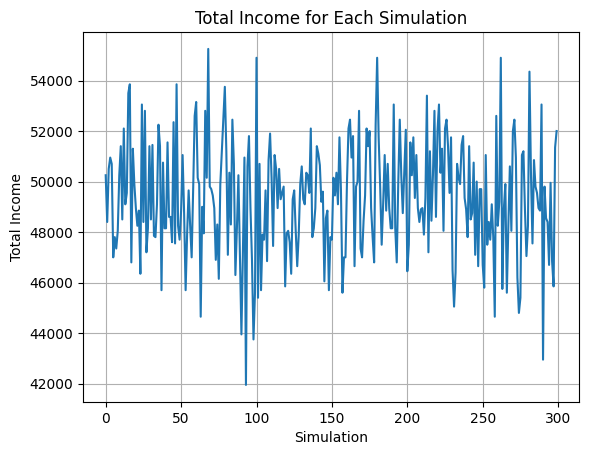

In [30]:
# 繪製折線圖
plt.plot(total_income_list, linestyle='-')
plt.title('Total Income for Each Simulation')
plt.xlabel('Simulation')
plt.ylabel('Total Income')
plt.grid(True)
plt.show()

In [31]:
'''使用 FCFS 模擬'''
total_income_list_fcfs = []  # 用來存總收益的 list

# 模擬 300 次
for sim_time in range(300):
    
    total_income = 0  # 初始總收入為 0
    remaining_seats = seats  # 初始座位數量
    
    # 每次模擬的過程
    for time_point in range(1, time_space+1):
        
        print("-------------" ,time_point, "-----------------")
        
        # 生成顧客
        customer_type, price = generate_customer(time_point, customers, willing_to_pay, triangle_y_values)

        # 若還有剩餘座位
        if remaining_seats > 0:
            
            remaining_seats -= 1
            total_income += price        
            
        else:
            print("No remaining seats.")

        print(f"Total Income: {total_income}")
        
    total_income_list_fcfs.append(total_income)

------------- 1 -----------------
[1.0, 0.0, 0.0, 0.0]  at day:  1
random_number: 0.6806755254261853, customer_index: 0, customer_type: f, price: 0
Total Income: 0
------------- 2 -----------------
[0.967, 0.002, 0.031, 0.0]  at day:  2
random_number: 0.576215237229465, customer_index: 0, customer_type: f, price: 0
Total Income: 0
------------- 3 -----------------
[0.933, 0.004, 0.063, 0.0]  at day:  3
random_number: 0.047349951942211366, customer_index: 0, customer_type: f, price: 0
Total Income: 0
------------- 4 -----------------
[0.9, 0.006, 0.094, 0.0]  at day:  4
random_number: 0.4440806442294367, customer_index: 0, customer_type: f, price: 0
Total Income: 0
------------- 5 -----------------
[0.865, 0.009, 0.126, 0.0]  at day:  5
random_number: 0.48822589549562667, customer_index: 0, customer_type: f, price: 0
Total Income: 0
------------- 6 -----------------
[0.832, 0.011, 0.157, 0.0]  at day:  6
random_number: 0.9923427356341934, customer_index: 2, customer_type: M, price: 500


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




------------- 68 -----------------
[0.10099999999999998, 0.145, 0.626, 0.128]  at day:  68
random_number: 0.9492432093020614, customer_index: 3, customer_type: K, price: 450
Total Income: 25500
------------- 69 -----------------
[0.09899999999999998, 0.147, 0.621, 0.133]  at day:  69
random_number: 0.7565885224997794, customer_index: 2, customer_type: M, price: 500
Total Income: 26000
------------- 70 -----------------
[0.09799999999999998, 0.149, 0.615, 0.138]  at day:  70
random_number: 0.4347119641401701, customer_index: 2, customer_type: M, price: 500
Total Income: 26500
------------- 71 -----------------
[0.09699999999999998, 0.151, 0.61, 0.142]  at day:  71
random_number: 0.9198586892565375, customer_index: 3, customer_type: K, price: 450
Total Income: 26950
------------- 72 -----------------
[0.09599999999999997, 0.153, 0.604, 0.147]  at day:  72
random_number: 0.5550874942501569, customer_index: 2, customer_type: M, price: 500
Total Income: 27450
------------- 73 -------------

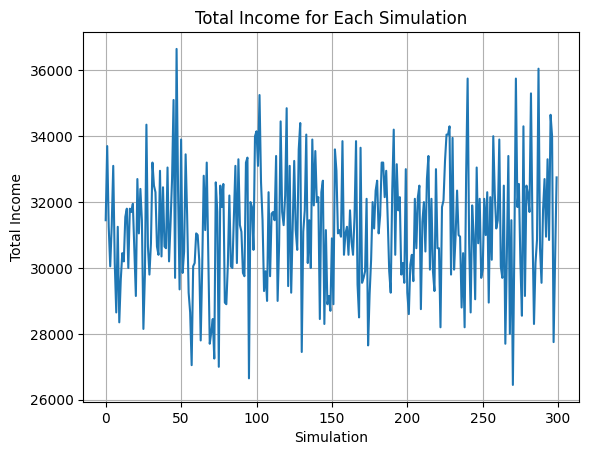

In [32]:
# 繪製折線圖
plt.plot(total_income_list_fcfs, linestyle='-')
plt.title('Total Income for Each Simulation')
plt.xlabel('Simulation')
plt.ylabel('Total Income')
plt.grid(True)
plt.show()

In [33]:
average_income_fcfs = np.mean(total_income_list_fcfs)
print(f"Average Income after {sim_time+1} simulation:", average_income_fcfs)

Average Income after 300 simulation: 31221.666666666668


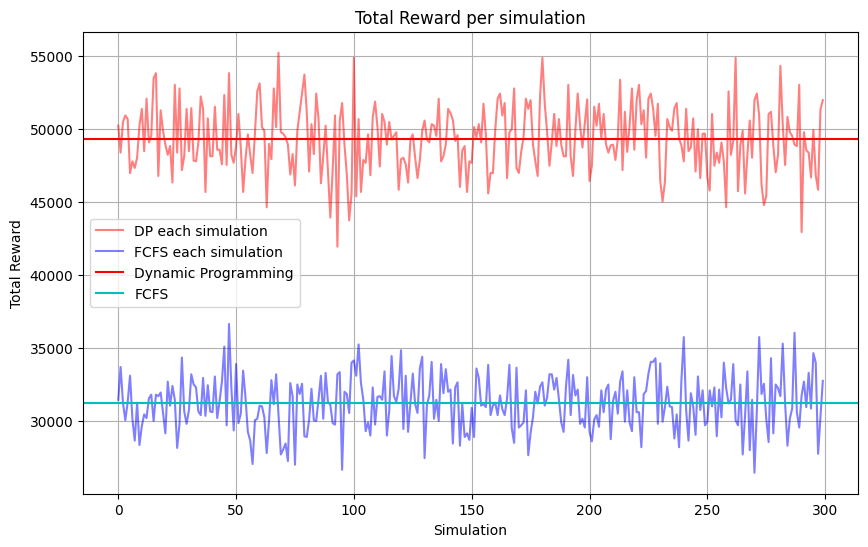

In [34]:
# 繪製圖表
plt.figure(figsize=(10, 6))  
plt.plot(range(300), total_income_list, label='DP each simulation', alpha=0.5, color='r')
plt.plot(range(300), total_income_list_fcfs, label='FCFS each simulation', alpha=0.5, color='b')
plt.axhline(y=average_income, color='r', label='Dynamic Programming')
plt.axhline(y=average_income_fcfs, color='c', label='FCFS')
plt.xlabel('Simulation')
plt.ylabel('Total Reward')
plt.title('Total Reward per simulation')
plt.legend()  
plt.grid(True)
plt.show()